## This notebook explore the ML approach for thickness map recovering
Created by: Zhiyuan Guo\
Date: 2/4/2021

In [1]:
# Import necessary package
from mpl_toolkits import mplot3d
import tensorflow as tf
from tensorflow import keras
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import GRF
from scipy.ndimage import gaussian_filter

 
 
### Open Simulated Training data: Details on the parameters of the simulated model can be found in the primary header

In [2]:
wlen = np.arange(870,990,10)
hdu = fits.open('../Sim_Data.fits')
sim = hdu[1].data['Sim']
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
CREATOR = 'Zhiyuan Guo'                                                         
DATE    = '2/3/2021'                                                            
MAP_ID  = 'Fractal_dimension= 0.8,n=100,seed = 12'                              
BANDPASS= '2nm     '                                                            
DIM     = '100X100 pixel per wavelength'                                        
SPACING = 'S:870nm , E:990nm , Step: 10nm'                                      
MODEL   = 'Vacuum MgF2 Ta2O5 Si SiO2 Si SiO2 Epoxy Si Si3N4'                    
THICK   = 'np.inf, 0.1221,0.0441,100., 0.1, 0.3,1.,14.8+d_si2,130-d_si2, np.inf'

### Based on the info of 'MAP_ID' in the header file, Let's see what does the underlying field looks like for this simulated data set

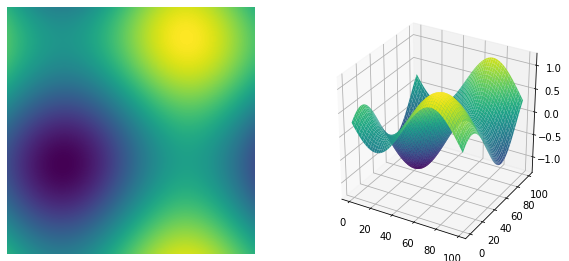

In [5]:
thick = GRF.plot_field(fractal_dimension= 0.8,n=100,seed = 12,scale_factor =1.2)

### Simulated Fringe pattern

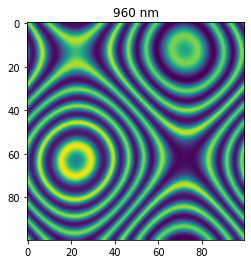

In [6]:
plt.imshow(sim[9],interpolation='bicubic');
plt.title('%i nm'%wlen[9]);

### Extract fringe amplitude map : the fringe amplitude at each pixel as a function of wavelength

In [7]:
Amp_map = []
for i in range(len(sim)):
    Fringe_map = sim[i]
    a = (np.max(Fringe_map[80,:])+np.min(Fringe_map[80,:]))/2
    A = (Fringe_map)/a-1
    Amp_map.append(A)

In [8]:
# Reshape thickness map & Fringe amplitude map from (100,100) to (10000,) & (10000,12)
th_map = thick.reshape(10000,)+14.8

a = []
fr_map = []
for q in range(100):
    for p in range(100):
        for m in range(len(sim)):
                a.append(Amp_map[m][q,p])
        fr_map.append(a)
        a = []
fr_map = np.array(fr_map)

print(fr_map.shape,th_map.shape)

(10000, 12) (10000,)


### Some example pixel values of Fringe map for training

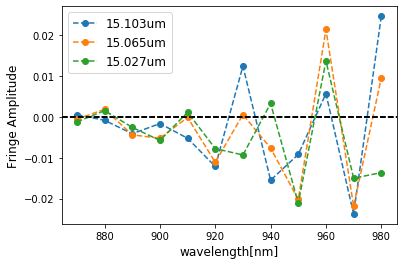

In [9]:
for i in range(3):
    wlen = np.arange(870,990,10)
    plt.plot(wlen,fr_map[100+i],'--o',label = '%.3fum'%th_map[100+i])
    plt.axhline(0,color = 'black',ls = '--')
    plt.xlabel('wavelength[nm]',fontsize = 12)
    plt.ylabel('Fringe Amplitude',fontsize = 12)
    plt.legend(loc = 'upper left',fontsize = 12)

## Construct Dense Neutral Network

In [10]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=[12]),
  tf.keras.layers.Dense(6, activation='tanh'),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

### Use the first 8000 data as training set, the other 2000 points for testing set

In [11]:
# Train data
# This may took serveral minutes
model.fit(fr_map[:8000],th_map[:8000], epochs = 1500,verbose = False)

In [12]:
# Using the model to predict thickness for testing set
predict = model.predict([fr_map[8000:]])
# reshape prediction data & truth data for 2D visualization
predict = predict.reshape(20,100)
Truth = th_map[8000:].reshape(20,100)

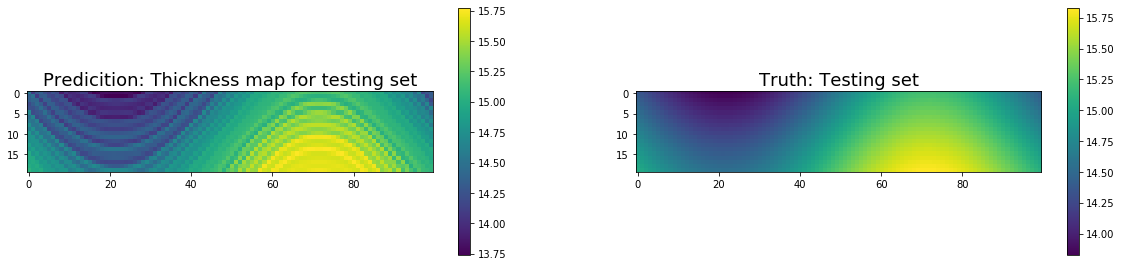

In [13]:
plt.figure(figsize = (20,10))
plt.subplot(221)
plt.title('Predicition: Thickness map for testing set',fontsize = 18)
plt.imshow(predict)
plt.colorbar()
plt.subplot(222)
plt.title('Truth: Testing set',fontsize = 18)
plt.imshow(Truth)
plt.colorbar();

### Prediction not so well, let's cheat via using a guassian kernel to smooth the prediction

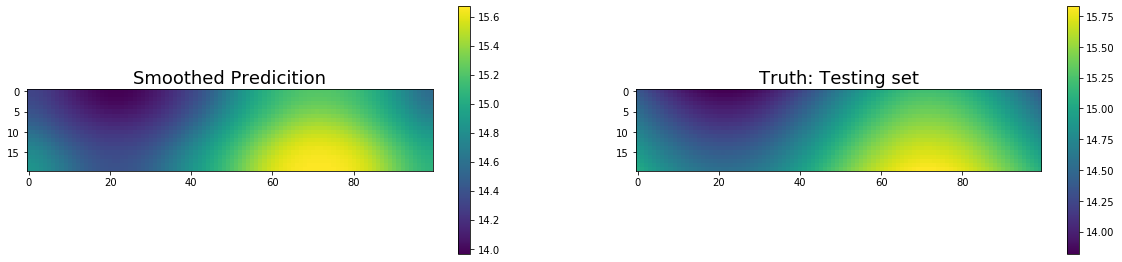

In [14]:
predict_smooth = gaussian_filter(predict, sigma=4)
plt.figure(figsize = (20,10))
plt.subplot(221)
plt.title('Smoothed Predicition',fontsize = 18)
plt.imshow(predict_smooth)
plt.colorbar()
plt.subplot(222)
plt.title('Truth: Testing set',fontsize = 18)
plt.imshow(Truth)
plt.colorbar();

### Much better after smoothing, check how does the smoothed data agree with True data

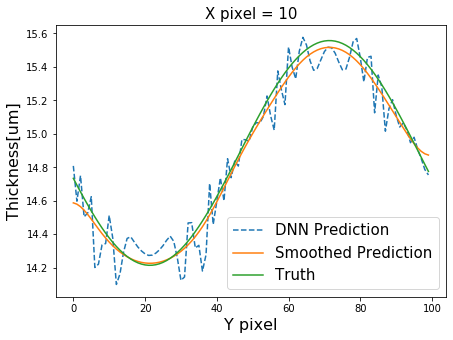

In [16]:
plt.figure(figsize = (7,5))
plt.title('X pixel = 10',fontsize = 15)
plt.plot(predict[10,:],'--',label = 'DNN Prediction')
plt.plot(predict_smooth[10,:],label = 'Smoothed Prediction')
plt.plot(Truth[10,:],label = 'Truth')
plt.legend(loc = 'best',fontsize = 15)
plt.xlabel('Y pixel',fontsize = 16)
plt.ylabel('Thickness[um]',fontsize = 16);

### Try doing prediction for a different fringe pattern

In [17]:
hdu2 = fits.open('../Sim_Data2.fits')
sim2 = hdu2[1].data['Sim']
hdu2[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
CREATOR = 'Zhiyuan Guo'                                                         
DATE    = '2/4/2021'                                                            
MAP_ID  = 'Fractal_dimension= 0.8,n=100,seed = 121'                             
BANDPASS= '2nm     '                                                            
DIM     = '100X100 pixel per wavelength'                                        
SPACING = 'S:870nm , E:990nm , Step: 10nm'                                      
MODEL   = 'Vacuum MgF2 Ta2O5 Si SiO2 Si SiO2 Epoxy Si Si3N4'                    
THICK   = 'np.inf, 0.1221,0.0441,100., 0.1, 0.3,1.,14.8+d_si2,130-d_si2, np.inf'

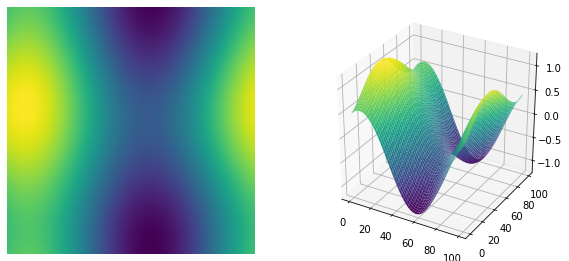

In [18]:
thick2 = GRF.plot_field(fractal_dimension= 0.8,n=100,seed = 121,scale_factor =1.2)

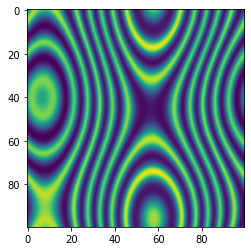

In [21]:
plt.imshow(Amp_map2[9],interpolation='bicubic')

In [27]:
# Process data
th_map = thick2.reshape(10000,)+14.8

Amp_map2 = []
for i in range(len(sim2)):
    Fringe_map = sim2[i]
    a = (np.max(Fringe_map[80,:])+np.min(Fringe_map[80,:]))/2
    A = (Fringe_map)/a-1
    Amp_map2.append(A)
    
a = []
fr_map2 = []
for q in range(100):
    for p in range(100):
        for m in range(len(sim)):
                a.append(Amp_map2[m][q,p])
        fr_map2.append(a)
        a = []
fr_map2 = np.array(fr_map2)
print(fr_map2.shape)

(10000, 12)


In [28]:
# Using the model to predict thickness for testing set
predict = model.predict([fr_map2])
# reshape prediction data & truth data for 2D visualization
predict = predict.reshape(100,100)

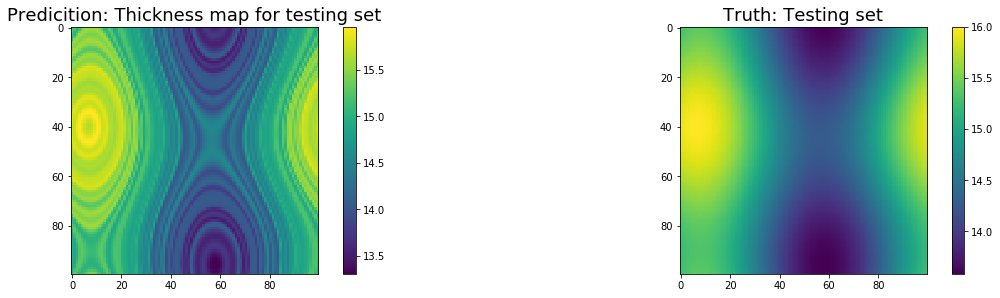

In [33]:
plt.figure(figsize = (20,10))
plt.subplot(221)
plt.title('Predicition: Thickness map for testing set',fontsize = 18)
plt.imshow(predict)
plt.colorbar()
plt.subplot(222)
plt.title('Truth: Testing set',fontsize = 18)
plt.imshow(thick2+14.8)
plt.colorbar();

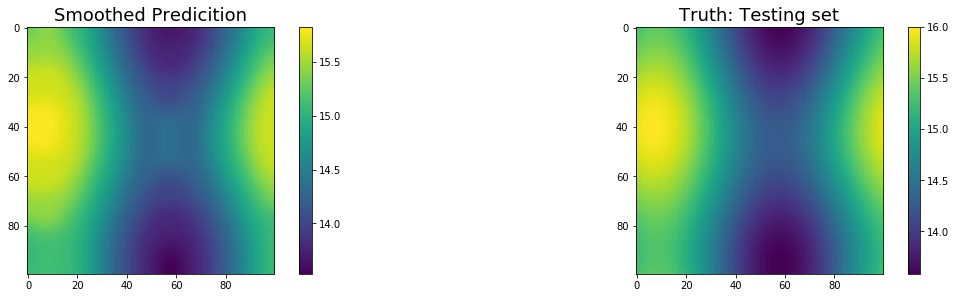

In [34]:
predict_smooth = gaussian_filter(predict, sigma=4)
plt.figure(figsize = (20,10))
plt.subplot(221)
plt.title('Smoothed Predicition',fontsize = 18)
plt.imshow(predict_smooth)
plt.colorbar()
plt.subplot(222)
plt.title('Truth: Testing set',fontsize = 18)
plt.imshow(thick2+14.8)
plt.colorbar();

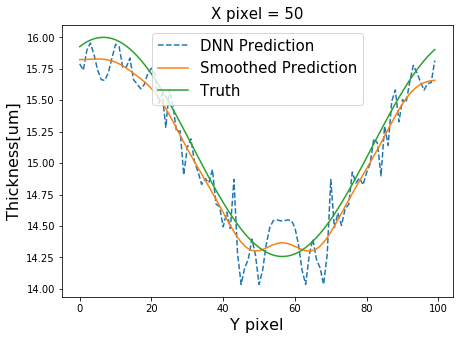

In [39]:
plt.figure(figsize = (7,5))
plt.title('X pixel = 50',fontsize = 15)
xpixel = 40
plt.plot(predict[xpixel,:],'--',label = 'DNN Prediction')
plt.plot(predict_smooth[xpixel,:],label = 'Smoothed Prediction')
plt.plot(thick2[xpixel,:]+14.8,label = 'Truth')
plt.legend(loc = 'best',fontsize = 15)
plt.xlabel('Y pixel',fontsize = 16)
plt.ylabel('Thickness[um]',fontsize = 16);

### Store Predicted data

In [42]:
from astropy.io import fits
col1 = fits.Column(name='Prediction', format='1D', array=predict_smooth.reshape(10000,))
hdu = fits.BinTableHDU.from_columns([col1])
hdu.writeto('Predict_data.fits')